### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
    Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees, identify right error metrics.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf

from keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import Callback
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline  


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


###### fix random seed for reproducibility

    Generally, Keras gets its source of randomness from the NumPy random number generator.
    
    In addition, TensorFlow has its own random number generator that must also be seeded by calling the set_random_seed() function immediately after the NumPy random number generator, as follows:

In [0]:
np.random.seed(123)

tf.set_random_seed(123)

Get current working directory

In [0]:
PATH = os.getcwd()

Change directory

In [0]:
os.chdir(PATH)

#### Loading the data

In [0]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [0]:
data.shape

(61589, 23)

Display the columns

In [0]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [0]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [0]:
data[:6]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No
3,1758220,46,2.0,0,0,0,0,1,2,6,...,0,0.75,0.90,0,Yes,No,No,Yes,No,No
4,1360312,2,2.0,0,4,6,10,2,2,5,...,0,0.97,0.92,0,No,No,No,Yes,No,No
5,3002608,297,12.0,0,0,0,0,5,6,44,...,0,0.58,0.75,0,Yes,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

    For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

        The top is the most common value.

        The freq is the most common value’s frequency.

In [0]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [0]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 

    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [0]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [0]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [0]:
np.size(np.unique(data.sku))

61589

In [0]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [0]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [0]:
print (data.shape)

(61589, 22)


Since the number of missing values is about 5%. For initial analysis we ignore all these records

In [0]:
data = data.dropna(axis=0)

In [0]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [0]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [0]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [0]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [0]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [0]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

In [0]:
pd.value_counts(data['went_on_backorder_Yes'])/data['went_on_backorder_Yes'].count() * 100

0    81.148386
1    18.851614
Name: went_on_backorder_Yes, dtype: float64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [0]:
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])

In [0]:
print(X_train.shape)
print(X_test.shape)

(40730, 21)
(17456, 21)


In [0]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


In [0]:
print(pd.value_counts(y_train)/y_train.size * 100)
print(pd.value_counts(y_test)/y_test.size * 100)

0    81.14903
1    18.85097
dtype: float64
0    81.146884
1    18.853116
dtype: float64


#### Model with Relu as activation in hidden layer, Adam optimizer,Modified Xavier

In [0]:
np.random.seed(123)
tf.set_random_seed(123)

#### Function for creation of model

In [0]:
def model_def(h_activation, o_activation, kernel_init):
    
    model=Sequential()
    
    model.add(Dense(25, input_dim=21, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(15, activation=h_activation, kernel_initializer=kernel_init))
    model.add(Dense(1, activation=o_activation, kernel_initializer=kernel_init))
    
    return model 

In [0]:
relu_model= model_def(h_activation='relu', o_activation='sigmoid', kernel_init='glorot_normal')

In [0]:
relu_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
relu_model_history = relu_model.fit(X_train, y_train, epochs=100,
                                    batch_size= 64,
                                    validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 53us/step - loss: 0.4579 - acc: 0.8743 - val_loss: 0.3604 - val_acc: 0.8888
Epoch 2/100
32584/32584 [==============================] - 1s 22us/step - loss: 0.4041 - acc: 0.8858 - val_loss: 0.3899 - val_acc: 0.8880
Epoch 3/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3808 - acc: 0.8917 - val_loss: 0.4580 - val_acc: 0.8790A: 0s - loss: 0.3850 - acc: 0.89
Epoch 4/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3608 - acc: 0.8943 - val_loss: 0.3388 - val_acc: 0.8992
Epoch 5/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3472 - acc: 0.8942 - val_loss: 0.5568 - val_acc: 0.8494
Epoch 6/100
32584/32584 [==============================] - 1s 25us/step - loss: 0.3465 - acc: 0.8936 - val_loss: 0.3207 - val_acc: 0.8979
Epoch 7/100
32584/32584 [==============================] - 1s 24us/step - loss: 0.3183 - ac

##### Plot

In [0]:
print(relu_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


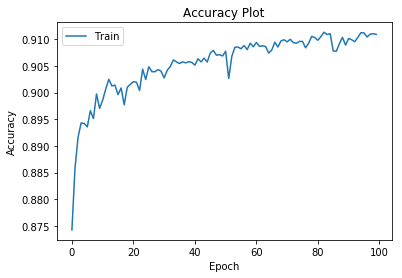

In [0]:
plt.plot(relu_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

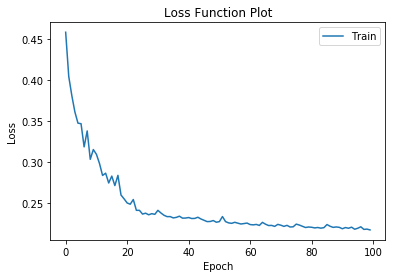

In [0]:
plt.plot(relu_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [0]:
train_relu_model_pred = relu_model.predict_classes(X_train)
test_relu_model_pred = relu_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [0]:
confusion_matrix_train = confusion_matrix(y_train, train_relu_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_relu_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31362  1690]
 [ 1949  5729]]
[[13361   804]
 [  903  2388]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [0]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9488684497155997
Train TPR:  0.7461578536077104
Train Accuracy:  0.9106555364596121
-----------------------
Test TNR:  0.9432403812213201
Test TPR:  0.7256153144940748
Test Accuracy:  0.902211274060495


#### Model with Dropout

In [0]:
np.random.seed(123)
tf.set_random_seed(123)

In [0]:
dropout_model = Sequential()
dropout_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [0]:
dropout_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 25)                550       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                390       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [0]:
dropout_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
dropout_model_history = dropout_model.fit(X_train, y_train, epochs=100,
                                          batch_size=64, 
                                          validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 2s 54us/step - loss: 1.4256 - acc: 0.7702 - val_loss: 0.4122 - val_acc: 0.8107
Epoch 2/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.6055 - acc: 0.8121 - val_loss: 0.3794 - val_acc: 0.8048
Epoch 3/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4562 - acc: 0.8133 - val_loss: 0.3662 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.4247 - acc: 0.8126 - val_loss: 0.3600 - val_acc: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 29us/step - loss: 0.3929 - acc: 0.8129 - val_loss: 0.3556 - val_acc: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 28us/step - loss: 0.3808 - acc: 0.8131 - val_loss: 0.3420 - val_acc: 0.8048
Epoch 7/100
32584/32584 [==============================] - 1s 27us/step - loss: 0.3688 - acc: 0.8129 - val_loss: 0.3209 - v

##### Plot

In [0]:
print(dropout_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


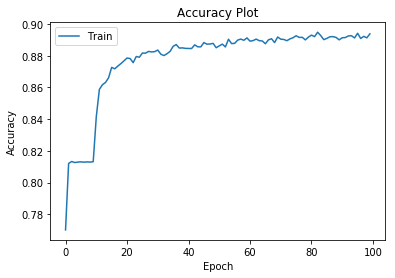

In [0]:
plt.plot(dropout_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

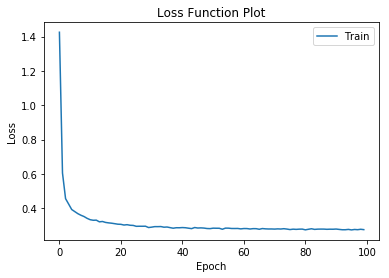

In [0]:
plt.plot(dropout_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [0]:
train_dropout_model_pred = dropout_model.predict_classes(X_train)
test_dropout_model_pred = dropout_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [0]:
confusion_matrix_train = confusion_matrix(y_train, train_dropout_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_dropout_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31131  1921]
 [ 1954  5724]]
[[13283   882]
 [  882  2409]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [0]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9418794626648916
Train TPR:  0.7455066423547799
Train Accuracy:  0.9048612816106064
-----------------------
Test TNR:  0.937733851041299
Test TPR:  0.731996353691887
Test Accuracy:  0.8989459211732356


#### Model with Batch Normalization

In [0]:
np.random.seed(123)
tf.set_random_seed(123)

In [0]:
bn_model = Sequential()
bn_model.add(Dense(25, input_dim=21, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(15, activation='relu', kernel_initializer="glorot_normal"))
bn_model.add(BatchNormalization())
bn_model.add(Dense(1, activation='sigmoid',kernel_initializer="glorot_normal"))

In [0]:
bn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 25)                550       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_8 (Dense)              (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total params: 1,116
Trainable params: 1,036
Non-trainable params: 80
_________________________________________________________________


In [0]:
bn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
bn_model_history = bn_model.fit(X_train, y_train, epochs=100,
                                batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 4s 120us/step - loss: 0.4393 - acc: 0.8222 - val_loss: 0.5648 - val_acc: 0.8049
Epoch 2/100
32584/32584 [==============================] - 1s 45us/step - loss: 0.3058 - acc: 0.8656 - val_loss: 0.4961 - val_acc: 0.8052
Epoch 3/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.2865 - acc: 0.8755 - val_loss: 0.4756 - val_acc: 0.8048
Epoch 4/100
32584/32584 [==============================] - 1s 39us/step - loss: 0.2791 - acc: 0.8793 - val_loss: 0.4765 - val_acc: 0.8049
Epoch 5/100
32584/32584 [==============================] - 1s 38us/step - loss: 0.2676 - acc: 0.8864 - val_loss: 0.4689 - val_acc: 0.8053
Epoch 6/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.2641 - acc: 0.8889 - val_loss: 0.4807 - val_acc: 0.8047
Epoch 7/100
32584/32584 [==============================] - 1s 37us/step - loss: 0.2619 - acc: 0.8876 - val_loss: 0.4686 - 

##### Plot

In [0]:
print(bn_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


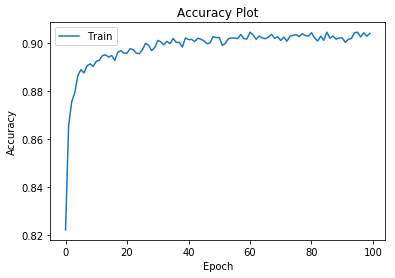

In [0]:
plt.plot(bn_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

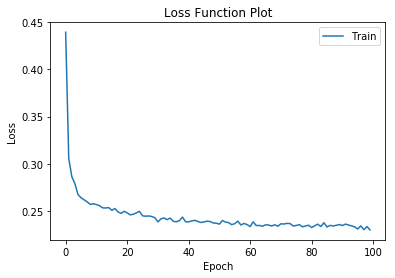

In [0]:
plt.plot(bn_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [0]:
train_bn_model_pred = bn_model.predict_classes(X_train)
test_bn_model_pred = bn_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [0]:
confusion_matrix_train = confusion_matrix(y_train, train_bn_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bn_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[33044     8]
 [ 7673     5]]
[[14160     5]
 [ 3287     4]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [0]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)
print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9997579571584171
Train TPR:  0.0006512112529304506
Train Accuracy:  0.8114166462067273
-----------------------
Test TNR:  0.9996470172961525
Test TPR:  0.001215436037678517
Test Accuracy:  0.8114115490375802


#### model with weight decay

#### Find the best Weight Decay value

In [0]:
weight_decay_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

In [0]:
def l2_model_func(l2_value):
    # create model
    l2_model = Sequential()
    
    l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(l2_value), kernel_initializer="glorot_normal"))
    l2_model.add(Dropout(0.5))
    l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(l2_value),kernel_initializer="glorot_normal"))
    
    # Compile model
    l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return l2_model   

In [0]:
hist_loss=[]

for weight_decay in weight_decay_list:
    
    np.random.seed(123)
    tf.set_random_seed(123)
    
    l2_model = l2_model_func(weight_decay)
    
    #Fit the model
    l2_model_history = l2_model.fit(X_train, y_train, epochs=1,
                                    validation_split=0.2, steps_per_epoch=50,
                                    validation_steps=50)
    
    hist_loss.append(l2_model_history.history['loss'])

Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 5s 109ms/step - loss: 6.0224 - acc: 0.6976 - val_loss: 4.1852 - val_acc: 0.8123
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 6s 111ms/step - loss: 2.6367 - acc: 0.7028 - val_loss: 1.2860 - val_acc: 0.8132
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 5s 109ms/step - loss: 2.2813 - acc: 0.7030 - val_loss: 1.0040 - val_acc: 0.8127
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 6s 123ms/step - loss: 2.2487 - acc: 0.7039 - val_loss: 0.9923 - val_acc: 0.8118
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 6s 128ms/step - loss: 2.2383 - acc: 0.7036 - val_loss: 1.0173 - val_acc: 0.8113
Train on 32584 samples, validate on 8146 samples
Epoch 1/1
50/50 [==============================] - 

In [0]:
# Get the weight decay and loss Dataframe
loss_weight_decay = pd.DataFrame([weight_decay_list, hist_loss]).T  

#Give the coloumn names
loss_weight_decay.columns=['weight_decay','loss']

#Sort the values and reset the index
loss_weight_decay=loss_weight_decay.sort_values('loss').reset_index().drop('index',axis=1)
loss_weight_decay

,weight_decay,loss
0,1e-05,[2.238338224887848]
1,1e-06,[2.2393694305419922]
2,0.0001,[2.248703348636627]
3,0.001,[2.281346399784088]
4,0.01,[2.636713740825653]
5,0.1,[6.022404823303223]


#### Build model with the best l2 value

In [0]:
np.random.seed(123)
tf.set_random_seed(123)

In [0]:
bst_l2_model = Sequential()

bst_l2_model.add(Dense(25, input_dim=21, activation='relu', kernel_regularizer=l2(0.0001),kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(15, activation='relu',kernel_regularizer=l2(0.0001), kernel_initializer="glorot_normal"))
bst_l2_model.add(Dropout(0.5))
bst_l2_model.add(Dense(1, activation='sigmoid',kernel_regularizer=l2(0.0001), kernel_initializer="glorot_normal"))

# Compile model
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
bst_l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_15 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 15)                390       
_________________________________________________________________
dropout_16 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 16        
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


In [0]:
bst_l2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
bst_l2_model_history = bst_l2_model.fit(X_train, y_train, epochs=100,
                                        batch_size=64, 
                                        validation_split=0.2, shuffle=True)

Train on 32584 samples, validate on 8146 samples
Epoch 1/100
32584/32584 [==============================] - 4s 110us/step - loss: 1.4156 - acc: 0.7727 - val_loss: 0.4382 - val_acc: 0.8055
Epoch 2/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.6137 - acc: 0.8099 - val_loss: 0.3854 - val_acc: 0.8047
Epoch 3/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4776 - acc: 0.8114 - val_loss: 0.3747 - val_acc: 0.8049
Epoch 4/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.4298 - acc: 0.8125 - val_loss: 0.3726 - val_acc: 0.8048
Epoch 5/100
32584/32584 [==============================] - 1s 41us/step - loss: 0.4042 - acc: 0.8127 - val_loss: 0.3654 - val_acc: 0.8048
Epoch 6/100
32584/32584 [==============================] - 1s 42us/step - loss: 0.3930 - acc: 0.8129 - val_loss: 0.3522 - val_acc: 0.8048
Epoch 7/100
32584/32584 [==============================] - ETA: 0s - loss: 0.3864 - acc: 0.812 - 1s 42us/step - loss: 0.38

Epoch 59/100
32584/32584 [==============================] - 1s 32us/step - loss: 0.2781 - acc: 0.8926 - val_loss: 0.2676 - val_acc: 0.8899
Epoch 60/100
32584/32584 [==============================] - 1s 29us/step - loss: 0.2775 - acc: 0.8938 - val_loss: 0.2596 - val_acc: 0.8961
Epoch 61/100
32584/32584 [==============================] - 1s 30us/step - loss: 0.2762 - acc: 0.8937 - val_loss: 0.2583 - val_acc: 0.8963
Epoch 62/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.2771 - acc: 0.8925 - val_loss: 0.2553 - val_acc: 0.8977
Epoch 63/100
32584/32584 [==============================] - 1s 33us/step - loss: 0.2762 - acc: 0.8936 - val_loss: 0.2558 - val_acc: 0.9006
Epoch 64/100
32584/32584 [==============================] - 1s 35us/step - loss: 0.2782 - acc: 0.8936 - val_loss: 0.2607 - val_acc: 0.8925
Epoch 65/100
32584/32584 [==============================] - 1s 34us/step - loss: 0.2771 - acc: 0.8940 - val_loss: 0.2564 - val_acc: 0.9022
Epoch 66/100
32584/32584 [=

##### Plot

In [0]:
print(bst_l2_model.history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


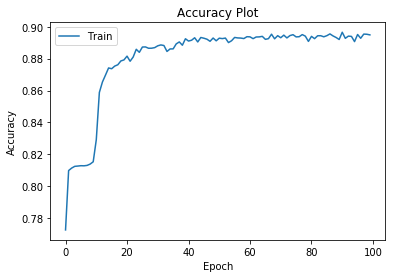

In [0]:
plt.plot(bst_l2_model.history.history['acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

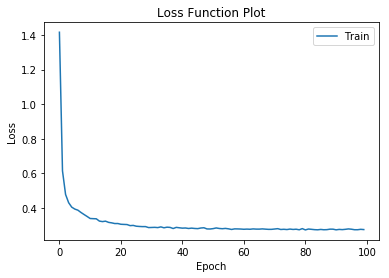

In [0]:
plt.plot(bst_l2_model.history.history['loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Predictions

In [0]:
train_bst_l2_model_pred = bst_l2_model.predict_classes(X_train)
test_bst_l2_model_pred = bst_l2_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [0]:
confusion_matrix_train = confusion_matrix(y_train, train_bst_l2_model_pred)
confusion_matrix_test = confusion_matrix(y_test, test_bst_l2_model_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[30956  2096]
 [ 1842  5836]]
[[13217   948]
 [  845  2446]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [0]:
Accuracy_Train_M6 =(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train_M6 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train_M6 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train_M6)
print("Train TPR: ",TPR_Train_M6)
print("Train Accuracy: ",Accuracy_Train_M6)

print("-----------------------")

Accuracy_Test_M6 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test_M6 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test_M6 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test_M6)
print("Test TPR: ",TPR_Test_M6)
print("Test Accuracy: ",Accuracy_Test_M6)

Train TNR:  0.9365847755052644
Train TPR:  0.760093774420422
Train Accuracy:  0.9033145101890498
-----------------------
Test TNR:  0.9330744793505118
Test TPR:  0.7432391370404132
Test Accuracy:  0.8972846012832264


### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/